In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg cmake > /dev/null 2>&1
!pip install --upgrade setuptools > /dev/null 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[classic_control] > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install tensorflow > /dev/null 2>&1
!pip install tensorflow-gpu==2.11.0
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
    

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
#import tensorflow_probability as tfp

In [ ]:
env = gym.make('Acrobot-v1')
env.seed(42)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")

6
3
1
----
[ 0.99849933  0.0547638   0.99992526 -0.01222401  0.07171959  0.0394736 ]
----
2
----
[ 0.9988263   0.0484355   0.99933636  0.03642501 -0.13198231  0.43717727]
-1.0
False
{}
----


In [ ]:
env1 = gym.make("CartPole-v1")
env1.seed(42)

state_shape1 = env1.observation_space.shape[0]
no_of_actions1 = env1.action_space.n

print(state_shape1)
print(no_of_actions1)
print(env1.action_space.sample())
print("----")

state1 = env1.reset()
''' This returns the initial state (when environment is reset) '''

print(state1)
print("----")

action1 = env1.action_space.sample()
''' We take a random action now '''

print(action1)
print("----")

next_state1, reward1, done1, info1 = env1.step(action1)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state1)
print(reward1)
print(done1)
print(info1)
print("----")

4
2
0
----
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
----
0
----
[ 0.02727336 -0.20172954  0.03625453  0.32351476]
1.0
False
{}
----


Q Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Replay Buffer

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Agent Class Definition

In [ ]:

'Agent Class Definition'

class TutorialAgent():

    def __init__(self, state_size, action_size, seed, update_rule):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.update_rule = update_rule

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Type-1 update
        Q_targets_next_type1 = self.qnetwork_target(next_states).detach()
        V_next = Q_targets_next_type1.mean(1).unsqueeze(1)
        A_next = Q_targets_next_type1 - V_next
        Q_targets_type1 = rewards + (gamma * (1 - dones) * (V_next + A_next - A_next.mean(1).unsqueeze(1)))

        # Type-2 update
        Q_targets_next_type2 = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets_type2 = rewards + (gamma * (1 - dones) * Q_targets_next_type2)

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss_type1 = F.mse_loss(Q_expected, Q_targets_type1)
        loss_type2 = F.mse_loss(Q_expected, Q_targets_type2)

        self.optimizer.zero_grad()
        if self.update_rule == "Type-1":
          loss_type1.backward()
        elif self.update_rule == "Type-2":
          loss_type2.backward()

        self.optimizer.step()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

Defining Dueling DQN Algorithm

In [ ]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
N_EPISODES = 500
EPS_DECAY = 0.995

def dueling_dqn(agent, update_rule, n_episodes=N_EPISODES, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=EPS_DECAY):
    scores = []
    scores_window_printing = deque(maxlen=10)
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_window_printing.append(score)

        eps = max(eps_end, eps_decay*eps)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            scores.append(np.mean(scores_window_printing))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 475.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break

    return scores

Function to run Dueling DQN for several iterations and to plot results

In [ ]:
def execute_dueling_dqn(agents, update_rules):
    rewards_iterations = {update_rule: [] for update_rule in update_rules}

    for update_rule, agent in agents.items():
        for iteration in range(5):
            print("Update Rule:", update_rule, "Iteration:", iteration + 1)
            agent.memory = ReplayBuffer(action_size=agent.action_size, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=42)
            rewards_history = dueling_dqn(agent=agent, update_rule=update_rule)
            rewards_iterations[update_rule].append(rewards_history)

    plt.title('Reward Curves for Different Update Rules')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')

    for update_rule, rewards_list in rewards_iterations.items():
        mean_rewards = np.mean(rewards_list, axis=0)
        std_rewards = np.std(rewards_list, axis=0)
        plt.plot(np.arange(mean_rewards.shape[0]) * 10, mean_rewards, label=f'Mean ({update_rule})', linewidth=1)
        plt.fill_between(np.arange(mean_rewards.shape[0]) * 10,
                         mean_rewards + std_rewards,
                         mean_rewards - std_rewards,
                         alpha=0.2)
    plt.legend()
    plt.show()

Update Rule: Type-1 Iteration: 1


<ipython-input-60-e3f63ac0edd5>:72: UserWarning: Using a target size (torch.Size([64, 3])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_type1 = F.mse_loss(Q_expected, Q_targets_type1)


Episode 100	Average Score: -362.00
Episode 200	Average Score: -177.56
Episode 300	Average Score: -156.07
Episode 400	Average Score: -144.90
Episode 500	Average Score: -143.60
Update Rule: Type-1 Iteration: 2
Episode 100	Average Score: -381.91
Episode 200	Average Score: -228.98
Episode 300	Average Score: -159.05
Episode 400	Average Score: -150.19
Episode 500	Average Score: -133.73
Update Rule: Type-1 Iteration: 3
Episode 100	Average Score: -378.55
Episode 200	Average Score: -234.69
Episode 300	Average Score: -172.89
Episode 400	Average Score: -141.52
Episode 500	Average Score: -142.90
Update Rule: Type-1 Iteration: 4
Episode 100	Average Score: -382.64
Episode 200	Average Score: -195.61
Episode 300	Average Score: -158.80
Episode 400	Average Score: -130.83
Episode 500	Average Score: -128.79
Update Rule: Type-1 Iteration: 5
Episode 100	Average Score: -380.89
Episode 200	Average Score: -202.50
Episode 300	Average Score: -156.30
Episode 400	Average Score: -140.88
Episode 500	Average Score: -

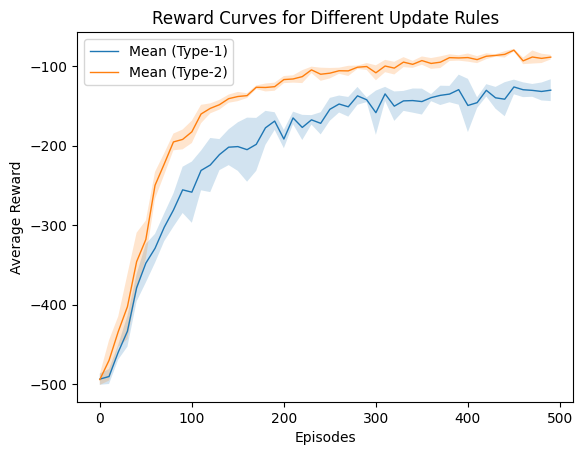

In [ ]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 20

# Initialization for Acrobot-v1 environment with Type-1 update rule
agent_acrobot_type1 = TutorialAgent(state_size=state_shape, action_size=action_shape, seed=10, update_rule="Type-1")

# Initialization for Acrobot-v1 environment with Type-2 update rule
agent_acrobot_type2 = TutorialAgent(state_size=state_shape, action_size=action_shape, seed=10, update_rule="Type-2")

agents = {"Type-1": agent_acrobot_type1, "Type-2": agent_acrobot_type2}
execute_dueling_dqn(agents=agents, update_rules=["Type-1", "Type-2"])

Update Rule: Type-1 Iteration: 1


<ipython-input-60-e3f63ac0edd5>:72: UserWarning: Using a target size (torch.Size([64, 3])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_type1 = F.mse_loss(Q_expected, Q_targets_type1)


Episode 100	Average Score: -356.80
Episode 200	Average Score: -196.08
Episode 300	Average Score: -164.33
Episode 400	Average Score: -149.53
Episode 500	Average Score: -139.13
Update Rule: Type-1 Iteration: 2
Episode 100	Average Score: -390.18
Episode 200	Average Score: -229.20
Episode 300	Average Score: -169.94
Episode 400	Average Score: -160.11
Episode 500	Average Score: -143.28
Update Rule: Type-1 Iteration: 3
Episode 100	Average Score: -397.43
Episode 200	Average Score: -214.68
Episode 300	Average Score: -180.25
Episode 400	Average Score: -149.73
Episode 500	Average Score: -140.75
Update Rule: Type-1 Iteration: 4
Episode 100	Average Score: -423.74
Episode 200	Average Score: -248.88
Episode 300	Average Score: -190.67
Episode 400	Average Score: -186.46
Episode 500	Average Score: -165.73
Update Rule: Type-1 Iteration: 5
Episode 100	Average Score: -398.66
Episode 200	Average Score: -249.22
Episode 300	Average Score: -179.82
Episode 400	Average Score: -165.59
Episode 500	Average Score: -

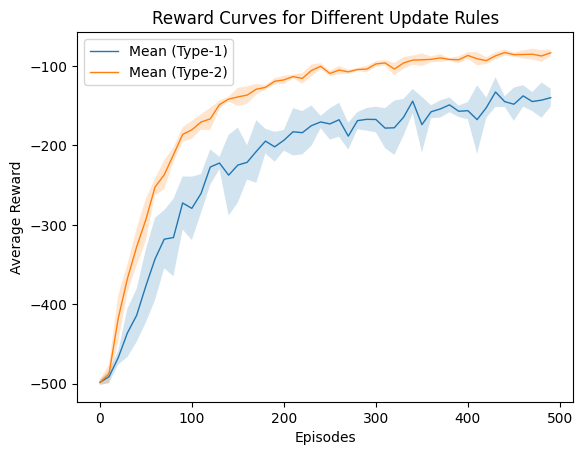

In [ ]:
# Initialization for cartpole-v1 environment with Type-1 update rule
agent_cartpole_type1 = TutorialAgent(state_size=state_shape, action_size=action_shape, seed=10, update_rule="Type-1")

# Initialization for cartpole-v1 environment with Type-2 update rule
agent_cartpole_type2 = TutorialAgent(state_size=state_shape, action_size=action_shape, seed=10, update_rule="Type-2")

agents = {"Type-1": agent_cartpole_type1, "Type-2": agent_cartpole_type2}
execute_dueling_dqn(agents=agents, update_rules=["Type-1", "Type-2"])

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


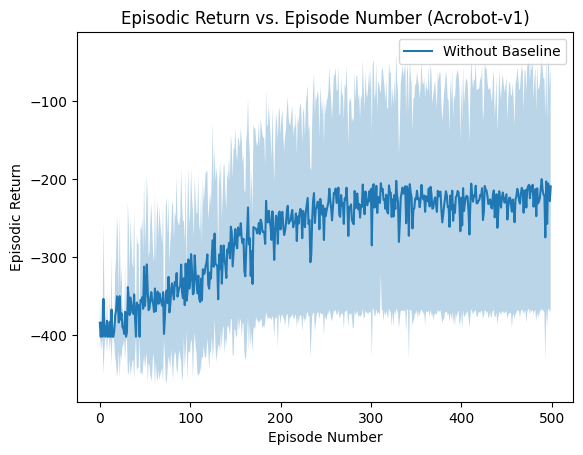

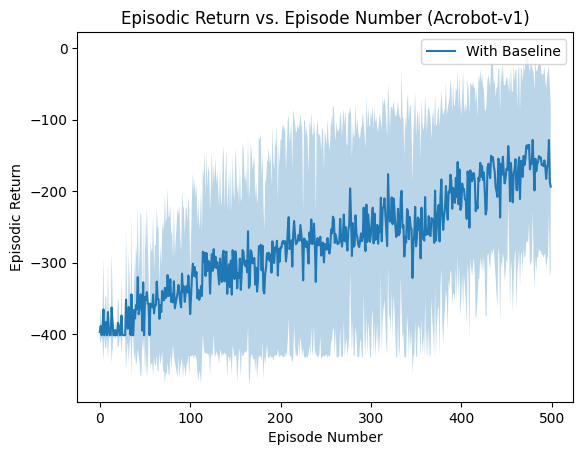

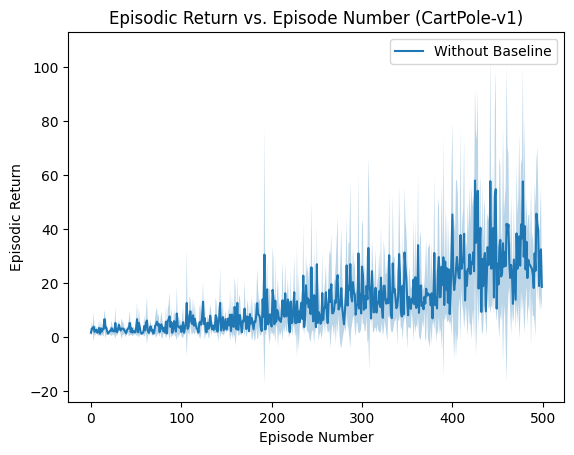

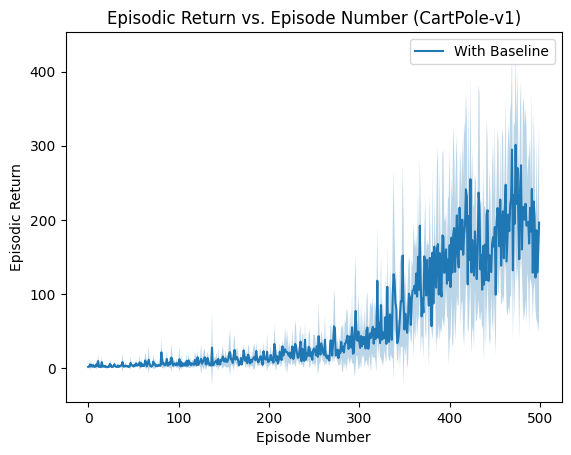

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Hyperparameters
gamma = 0.99
learning_rate = 1e-3
num_episodes = 500

# Environment setup
env_names = ['Acrobot-v1', 'CartPole-v1']
for env_name in env_names:
    env = gym.make(env_name)

    # Policy network
    class PolicyNetwork(nn.Module):
        def __init__(self, state_size, action_size, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(state_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, action_size)

        def forward(self, state):
            x = torch.relu(self.fc1(state))
            x = self.fc2(x)
            return torch.softmax(x, dim=-1)

    # Baseline network (only for REINFORCE with baseline)
    class BaselineNetwork(nn.Module):
        def __init__(self, state_size, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(state_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, 1)

        def forward(self, state):
            x = torch.relu(self.fc1(state))
            x = self.fc2(x)
            return x.squeeze()

    # REINFORCE without baseline
    def reinforce_without_baseline(env):
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        hidden_size = 64

        policy_net = PolicyNetwork(state_size, action_size, hidden_size)
        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

        episode_returns = []
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            rewards = []

            while True:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action_probs = policy_net(state_tensor)
                action = torch.multinomial(action_probs, 1).item()
                log_prob = torch.log(action_probs[action])
                next_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards.append(reward)

                if done:
                    returns = [sum(rewards[i:]) * (gamma ** i) for i in range(len(rewards))]
                    episode_return = sum(returns)
                    episode_returns.append(episode_return)

                    # Update the policy network
                    loss = -sum(returns) * sum(log_probs)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    break

                state = next_state

        return episode_returns

    # REINFORCE with baseline
    def reinforce_with_baseline(env):
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        hidden_size = 64

        policy_net = PolicyNetwork(state_size, action_size, hidden_size)
        baseline_net = BaselineNetwork(state_size, hidden_size)
        policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        baseline_optimizer = optim.Adam(baseline_net.parameters(), lr=learning_rate)

        episode_returns = []
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            rewards = []

            while True:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action_probs = policy_net(state_tensor)
                action = torch.multinomial(action_probs, 1).item()
                log_prob = torch.log(action_probs[action])
                next_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards.append(reward)

                if done:
                    returns = [sum(rewards[i:]) * (gamma ** i) for i in range(len(rewards))]
                    episode_return = sum(returns)
                    episode_returns.append(episode_return)

                    # Update the policy network and the baseline network
                    baseline = baseline_net(state_tensor)
                    policy_loss = -sum((torch.tensor(returns) - baseline.detach()) * torch.stack(log_probs))
                    baseline_loss = torch.mean((torch.tensor(returns) - baseline) ** 2)
                    policy_optimizer.zero_grad()
                    baseline_optimizer.zero_grad()
                    policy_loss.backward()
                    baseline_loss.backward()
                    policy_optimizer.step()
                    baseline_optimizer.step()
                    break

                state = next_state

        return episode_returns

    def reinforce_fn(env,baseline):
      if baseline == 0:
        return reinforce_without_baseline(env)
      else:
        return reinforce_with_baseline(env)

    baseline = [0,1]
    for baseline_ in baseline:
      all_returns = []
      for seed in range(42,47):
          np.random.seed(seed)
          torch.manual_seed(seed)
          returns = reinforce_fn(env,baseline_)
          all_returns.append(returns)
      mean_returns = np.mean(all_returns, axis=0)
      std_returns = np.std(all_returns, axis=0)
      plt.plot(mean_returns, label=f"{'With' if baseline_ == 1 else 'Without'} Baseline")
      plt.fill_between(range(len(mean_returns)), mean_returns - std_returns, mean_returns + std_returns, alpha=0.3)
      plt.title(f"Episodic Return vs. Episode Number ({env_name})")
      plt.xlabel("Episode Number")
      plt.ylabel("Episodic Return")
      plt.legend()
      plt.show()